<a href="https://colab.research.google.com/github/omicto/ubonn-eeg-experiments/blob/master/ubonn_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jugando con el Dataset de Ubonn
En este Notebook se utiliza el [dataset](http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3) de EEG de la Universidad de Bonn.

El notebook supone que se ha cargado a alguna carpeta de Google Drive el dataset, con una estructura similar a:
```
  dataset
   ├ F
     ├ F001.txt
     | ...
     | ...
     └ F100.txt
   ├ N
   ├ O
   ├ S
   └ Z
```
Esto es, preservando los nombres de las carpetas que contienen los archivos con las señales.



**Montamos Google Drive localmente**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Se debe asignar la ruta del directorio donde se guardo el dataset a la variable `ubonn_path`.

In [ ]:
ubonn_path = '/content/drive/My Drive/Universidad/Tesis/DataSets/data' #@param {type: "string"}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten, TimeDistributed, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras import metrics
from keras import backend

Using TensorFlow backend.


Definimos algunas funciones para leer los archivos y procesarlos como arreglos de *Numpy*

In [ ]:
def parse_file(signal_file):
    lines = signal_file.readlines()
    return np.fromiter(map(int, lines), dtype=np.int)

def segment_data(data: np.ndarray, steps: int, dim: int) -> np.ndarray:
    return data.reshape([steps, dim])

def read_file(file_path):#, timesteps, data_dim, data_length):
    with open(file_path) as f:
        return parse_file(f)

# https://stackoverflow.com/a/4602224/11449725
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# Carga del dataset
A continuación se define una función para cargar el dataset, además de algunos mapeos que nos resultarán útiles para etiquetar las señales.

In [ ]:

classes = {
    "HEALTHY"      :  0,
    "SEIZURE_FREE" :  1,
    "SEIZURE"      :  2
}

sets = {
    "A": {"class": classes["HEALTHY"],      "letter": "Z"},
    "B": {"class": classes["HEALTHY"],      "letter": "O"},
    "C": {"class": classes["SEIZURE_FREE"], "letter": "N"},
    "D": {"class": classes["SEIZURE_FREE"], "letter": "F"},
    "E": {"class": classes["SEIZURE"],      "letter": "S"}
}


La función `load_ubonn` se encarga de leer todos los archivos de texto que contienen las diferentes señales y transformarlos a `ndarray`s que nos permitirán manejarlos más fácilmente, regresa además un arreglo con la etiqueta de cada clase correspondiente a cada señal. Es decir `data[0]` corresponde con la etiqueta `label[0]`.

In [ ]:
def load_ubonn():
    '''
        Returns
         data   -   ndarray containing the raw signals
         labels -   ndarray containing the labels, using the following mapping
                    "HEALTHY"      :  0,
                    "SEIZURE_FREE" :  1,
                    "SEIZURE"      :  2
    '''
    base_path = ubonn_path
    data = []
    labels = []
    for key, dset in sets.items():
        directory = f'{base_path}/{dset["letter"]}'
        for filename in os.listdir(directory):
            signal = read_file(os.path.join(directory, filename))
            data.append(signal)
            labels.append(dset["class"])
    
    return np.array(data), np.array(labels)

Funcion que nos servira mas adelante para replicar el procesado del paper

In [ ]:
data_length = 4096 # d
timesteps = 2048
data_dim = data_length//timesteps # L
srate = 173.61

def reshape_signal(raw_signal):
    return segment_data(raw_signal[0:data_length], timesteps, data_dim)

In [ ]:

ubonn_data, ubonn_labels = load_ubonn()
ubonn_data.shape

(500, 4097)

In [ ]:
def gaussian_noise(signal, strength = 1):
    noise = np.random.normal(0,1,len(signal)) * strength
    return signal + noise

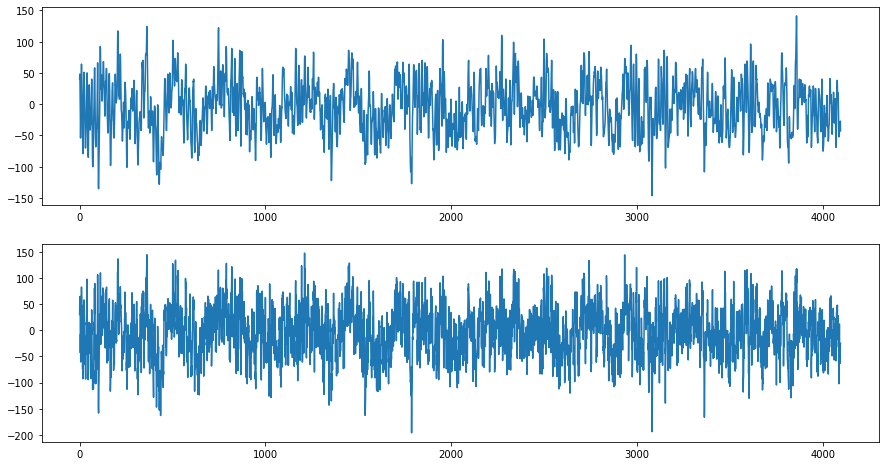

In [ ]:

raw = ubonn_data[0]
noisy = gaussian_noise(ubonn_data[0], strength=25)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))
ax1.plot(raw[:len(raw)])
ax2.plot(noisy[:len(raw)])

In [ ]:
temp = []
for signal in ubonn_data:
    temp.append(reshape_signal(signal))
reshaped_ubonn = np.array(temp)
reshaped_ubonn.shape

(500, 2048, 2)

In [ ]:
labels = np_utils.to_categorical(ubonn_labels)
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

*Randomizing* de los datos

In [ ]:
x, y = unison_shuffled_copies(reshaped_ubonn, labels)
X_train = x[:350]
X_test = x[350:]
y_train = y[:350]
y_test = y[350:]
X_train.shape

(350, 2048, 2)

In [ ]:
# create the model
model = Sequential()

model.add(LSTM(100, input_shape= (timesteps, data_dim), return_sequences = True))
model.add(TimeDistributed(Dense(50)))
model.add(GlobalAveragePooling1D())
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=40)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 2048, 100)         41200     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 2048, 50)          5050      
_________________________________________________________________
global_average_pooling1d_3 ( (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 46,403
Trainable params: 46,403
Non-trainable params: 0
_________________________________________________________________
None
Train on 350 samples, validate on 150 samples
Epoch 1/40
350/350 [==============================] - 18s 52ms/step - loss: 1.0610 - accuracy: 0.4971 - val_loss: 0.9945 - val_accuracy: 0.4667
Epoch 2/40
350/350 [==============================] -

In [ ]:
predictions = model.predict(X_test[0:10])
predictions

array([[7.4357737e-04, 7.6022203e-04, 9.9849617e-01],
       [1.6016329e-02, 9.8302507e-01, 9.5860579e-04],
       [6.4369338e-04, 9.9757200e-01, 1.7842564e-03],
       [4.3331943e-03, 9.9496198e-01, 7.0476672e-04],
       [2.2461468e-03, 3.1497380e-01, 6.8278009e-01],
       [5.7361362e-04, 9.8943031e-01, 9.9961320e-03],
       [7.4614577e-02, 2.7117291e-01, 6.5421247e-01],
       [7.2945273e-01, 2.6980442e-01, 7.4291474e-04],
       [3.6297613e-03, 9.9510634e-01, 1.2640159e-03],
       [9.8600149e-01, 1.3788314e-02, 2.1015547e-04]], dtype=float32)

In [ ]:
print(np.argmax(y_test[:10], axis0=1))
print(np.argmax(predictions, axis=1))



[2 1 1 1 2 1 2 1 1 0]
[2 1 1 1 2 1 2 0 1 0]
